### IMPORTS AND FUNCTIONS

In [217]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt 
import tensorflow as tf

import keras
from keras.models import Sequential 
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten,Dropout, MaxPooling2D
from keras.callbacks import EarlyStopping


from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import preprocess_input

from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.mobilenet_v2 import decode_predictions

from keras.applications.inception_v3 import InceptionV3 
from keras.applications.inception_v3 import decode_predictions

from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import load_img, img_to_array

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import classification_report

In [127]:
def plot_metrics(history):
    
    num_epochs = len(history.history['loss'])
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(range(1, num_epochs + 1), history.history['loss'], label='Train')
    ax1.plot(range(1, num_epochs + 1), history.history['val_loss'], label='Validation')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(range(1, num_epochs + 1), history.history['accuracy'], label='Train')
    ax2.plot(range(1, num_epochs + 1), history.history['val_accuracy'], label='Validation')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.show()


### READING DATA

In [233]:
path_train = './train_dataset/'

X_train = np.load(path_train + 'x_train.npy')
y_train = np.load(path_train + 'y_train.npy')

path_test = './test_dataset/'

X_test = np.load(path_test + 'x_test.npy')
y_test = np.load(path_test + 'y_test.npy')

print(f'Shape X_train={X_train.shape} \n      y_train= {y_train.shape}')
print(f'Shape X_test={X_test.shape} \n      y_test= {y_test.shape}')

Shape X_train=(2000, 128, 128, 1) 
      y_train= (2000, 2)
Shape X_test=(120, 128, 128, 1) 
      y_test= (120, 2)


In [ ]:
#Combien d’images avez-vous dans les datasets train, test et validation.  train = 2000, test = 120
#Quelle est la taille des images ? 128*128 pi

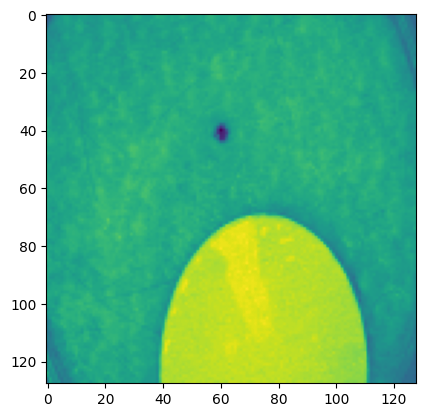

In [30]:
fig, ax = plt.subplots()
im = plt.imshow(X_train[1])
plt.show()

### KERAS

In [65]:
epoch = 50
filters = 64
dropout = 0.5
batch_size = 16
validation_split = 0.1

model = Sequential()

model.add(Conv2D(filters=filters, 
                 kernel_size=2, 
                 padding='same', 
                 activation='relu', 
                 input_shape=(128,128, 1))
         ) 

model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(dropout))
model.add(Flatten())
model.add(Dense(2, activation='softmax')) 

model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

callback = EarlyStopping(monitor="val_loss",patience=5)

model_fit = model.fit(x=X_train,
                      y=y_train,
                      epochs=epoch,
                      batch_size=batch_size,
                      validation_split=validation_split,
                      callbacks=[callback])

_, test_acc = model.evaluate(X_test, y_test)
print(f' \n For {model}, \n test_acc= {test_acc}')

Epoch 1/50
113/113 [==============================] - 11s 86ms/step - loss: 1.0847 - accuracy: 0.5611 - val_loss: 0.8964 - val_accuracy: 0.2850
Epoch 2/50
113/113 [==============================] - 9s 84ms/step - loss: 0.6066 - accuracy: 0.6733 - val_loss: 1.2331 - val_accuracy: 0.2000
Epoch 3/50
113/113 [==============================] - 10s 85ms/step - loss: 0.5767 - accuracy: 0.7089 - val_loss: 0.9795 - val_accuracy: 0.4600
Epoch 4/50
113/113 [==============================] - 9s 83ms/step - loss: 0.5577 - accuracy: 0.7139 - val_loss: 1.0614 - val_accuracy: 0.3450
Epoch 5/50
113/113 [==============================] - 9s 84ms/step - loss: 0.5129 - accuracy: 0.7628 - val_loss: 0.9967 - val_accuracy: 0.4750
Epoch 6/50
4/4 [==============================] - 0s 24ms/step - loss: 0.4817 - accuracy: 0.7583
 
 For <keras.src.engine.sequential.Sequential object at 0x0000014C393745B0>, 
 test_acc= 0.7583333253860474


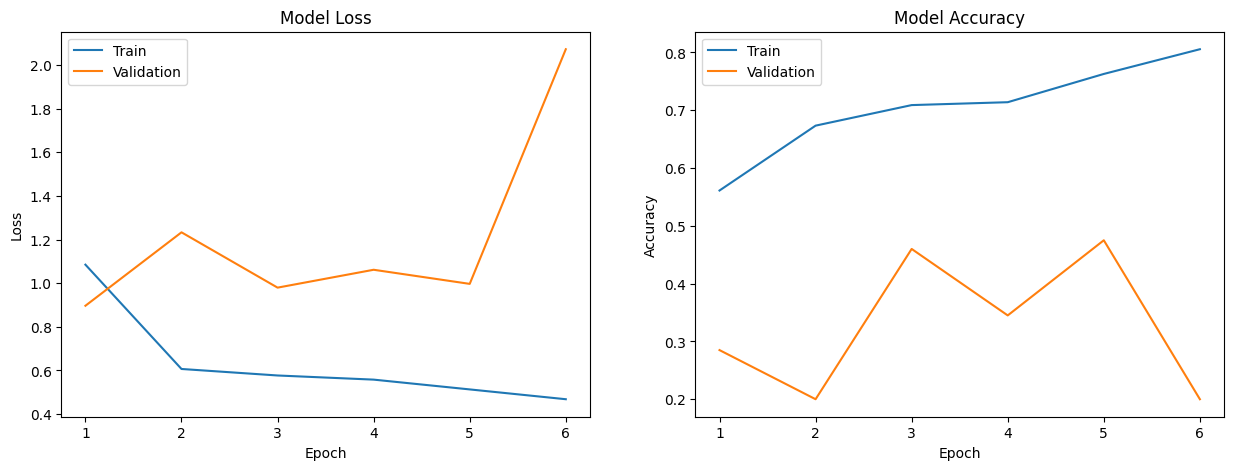

In [76]:
plot_metrics(model_fit)

In [90]:
def create_model(filters, kernel_size, pool_size, dropout_rate):
    model = Sequential()
    model.add(Conv2D(filters=filters, kernel_size=kernel_size, padding='same', activation='relu', input_shape=(128, 128, 1)))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Flatten())
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def evaluate_model(model, x_test, y_test):
    _, accuracy = model.evaluate(x_test, y_test, verbose=0)
    return accuracy

In [91]:
param_grid = {
    'filters': [32, 64],
    'kernel_size': [2],
    'pool_size': [2], 
    'dropout_rate': [0.3,0.5] 
}

In [95]:
best_accuracy = 0
best_params = None

for filters in param_grid['filters']:
    for kernel_size in param_grid['kernel_size']:
        for pool_size in param_grid['pool_size']:
            for dropout_rate in param_grid['dropout_rate']:
                model = create_model(filters, kernel_size, pool_size, dropout_rate)
                early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
                model.fit(X_train, y_train, epochs=25, batch_size=16, validation_split=0.1, verbose=1)

                accuracy = evaluate_model(model, X_test, y_test) 

                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_params = {
                        'filters': filters,
                        'kernel_size': kernel_size,
                        'pool_size': pool_size,
                        'dropout_rate': dropout_rate
                    }

print("Best Accuracy:", best_accuracy)
print("Best Parameters:", best_params)

Epoch 1/25
113/113 [==============================] - 4s 28ms/step - loss: 1.0874 - accuracy: 0.5683 - val_loss: 0.8980 - val_accuracy: 0.4100
Epoch 2/25
113/113 [==============================] - 3s 25ms/step - loss: 0.6075 - accuracy: 0.6578 - val_loss: 1.3105 - val_accuracy: 0.2700
Epoch 3/25
113/113 [==============================] - 3s 26ms/step - loss: 0.5768 - accuracy: 0.6922 - val_loss: 0.8405 - val_accuracy: 0.5500
Epoch 4/25
113/113 [==============================] - 3s 25ms/step - loss: 0.5153 - accuracy: 0.7472 - val_loss: 1.5694 - val_accuracy: 0.1450
Epoch 5/25
113/113 [==============================] - 3s 25ms/step - loss: 0.5031 - accuracy: 0.7439 - val_loss: 1.5122 - val_accuracy: 0.1750
Epoch 6/25
113/113 [==============================] - 3s 25ms/step - loss: 0.4278 - accuracy: 0.8272 - val_loss: 1.0094 - val_accuracy: 0.5150
Epoch 7/25
113/113 [==============================] - 3s 26ms/step - loss: 0.4225 - accuracy: 0.8194 - val_loss: 1.3741 - val_accuracy: 0.4650

In [ ]:
#Best Accuracy: 0.8999999761581421
#Best Parameters: {'filters': 32, 'kernel_size': 2, 'pool_size': 2, 'dropout_rate': 0.3}

In [96]:
epoch = 50
filters = 32
dropout = 0.3
batch_size = 16
validation_split = 0.1

model_best = Sequential()

model_best.add(Conv2D(filters=filters, 
                 kernel_size=2, 
                 padding='same', 
                 activation='relu', 
                 input_shape=(128,128, 1))
         ) 

model_best.add(MaxPooling2D(pool_size=2))
model_best.add(Dropout(dropout))
model_best.add(Flatten())
model_best.add(Dense(2, activation='softmax')) 

model_best.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

callback = EarlyStopping(monitor="val_loss",patience=5)

model_best_fit = model_best.fit(x=X_train,
                      y=y_train,
                      epochs=epoch,
                      batch_size=batch_size,
                      validation_split=validation_split,
                      callbacks=[callback])

_, test_acc = model_best.evaluate(X_test, y_test)
print(f' \n For {model_best}, \n test_acc= {test_acc}')

Epoch 1/50
113/113 [==============================] - 6s 48ms/step - loss: 0.9674 - accuracy: 0.5483 - val_loss: 1.3099 - val_accuracy: 0.1450
Epoch 2/50
113/113 [==============================] - 5s 47ms/step - loss: 0.6243 - accuracy: 0.6494 - val_loss: 1.0198 - val_accuracy: 0.3000
Epoch 3/50
113/113 [==============================] - 5s 44ms/step - loss: 0.5859 - accuracy: 0.6994 - val_loss: 1.6482 - val_accuracy: 0.1100
Epoch 4/50
113/113 [==============================] - 5s 44ms/step - loss: 0.5281 - accuracy: 0.7383 - val_loss: 0.9692 - val_accuracy: 0.4950
Epoch 5/50
113/113 [==============================] - 5s 43ms/step - loss: 0.4757 - accuracy: 0.7872 - val_loss: 0.8294 - val_accuracy: 0.5600
Epoch 6/50
113/113 [==============================] - 5s 43ms/step - loss: 0.4400 - accuracy: 0.8094 - val_loss: 1.1450 - val_accuracy: 0.5200
Epoch 7/50
113/113 [==============================] - 5s 43ms/step - loss: 0.4142 - accuracy: 0.8200 - val_loss: 1.5792 - val_accuracy: 0.3100

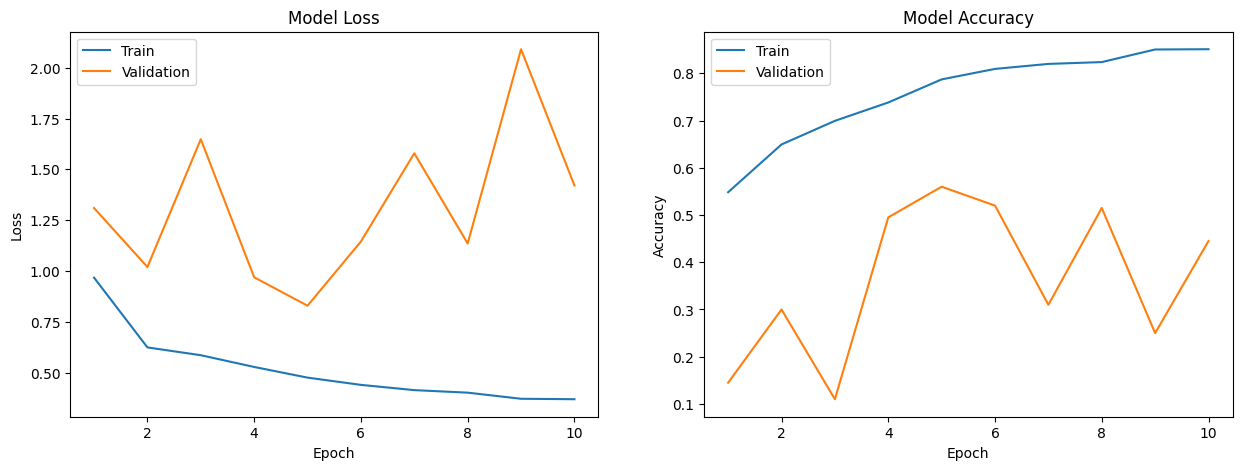

In [98]:
plot_metrics(model_best_fit)

### VGG16 with old data

In [239]:
import cv2
X_train_transformed = []
for x in X_train:
    new = cv2.cvtColor(x,cv2.COLOR_GRAY2RGB)
    X_train_transformed.append(new)
X_train_transformed = np.array(X_train_transformed)

X_test_transformed = []
for x in X_test:
    new = cv2.cvtColor(x,cv2.COLOR_GRAY2RGB)
    X_test_transformed.append(new)
X_test_transformed = np.array(X_test_transformed)


In [240]:
print(f'Shape X_train_transformed={X_train_transformed.shape} \n      X_test_transformed= {X_test_transformed.shape}')

Shape X_train_transformed=(2000, 128, 128, 3) 
      X_test_transformed= (120, 128, 128, 3)


## CATS

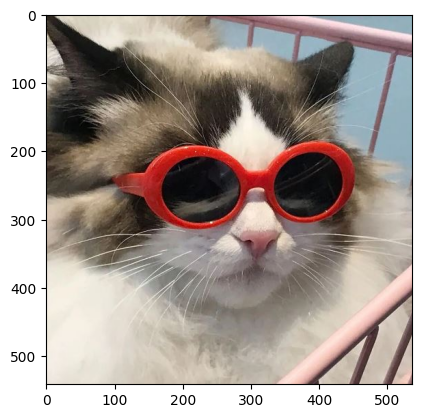

In [227]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

image = mpimg.imread("./pics/cat.jpg")
plt.imshow(image)
plt.show()

In [228]:
img = load_img('./pics/cat.jpg', target_size=(224, 224))  # Charger l'image
img = img_to_array(img)  # Convertir en tableau numpy
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  # Créer la collection d'images (un seul échantillon)
img = preprocess_input(img)  # Prétraiter l'image comme le veut VGG-16

### VGG16

In [229]:
model_cat = VGG16(weights='imagenet')

y = model_cat.predict(img)

output_neuron = np.argmax(y[0])
print('Most active neuron: {} ({:.2f}%)'.format(
    output_neuron,
    100 * y[0][output_neuron]
))

for name, desc, score in decode_predictions(y)[0]:
    print('- {} ({:.2f}%%)'.format(desc, 100 * score))

1/1 [==============================] - 1s 595ms/step
Most active neuron: 283 (67.76%)
- Persian_cat (67.76%%)
- sunglasses (13.66%%)
- Angora (2.06%%)
- Japanese_spaniel (2.02%%)
- feather_boa (1.64%%)


### MobileNetV2

In [208]:
model_MNV2 = MobileNetV2(weights='imagenet')
y = model_MNV2.predict(img)

output_neuron = np.argmax(y[0])
print('Most active neuron: {} ({:.2f}%)'.format(
    output_neuron,
    100 * y[0][output_neuron]
))

for name, desc, score in decode_predictions(y)[0]:
    print('- {} ({:.2f}%%)'.format(desc, 100 * score))

1/1 [==============================] - 2s 2s/step
Most active neuron: 643 (21.91%)
- mask (21.91%%)
- sunglasses (14.13%%)
- bib (9.38%%)
- pillow (6.53%%)
- water_bottle (2.57%%)


### InceptionV3

In [225]:
img = load_img('./pics/cat.jpg', target_size=(299, 299))  # Charger l'image
img = img_to_array(img)  # Convertir en tableau numpy
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  # Créer la collection d'images (un seul échantillon)
img = preprocess_input(img)  # Prétraiter l'image comme le veut VGG-16

model_IV3 = InceptionV3(weights='imagenet', include_top=True)
y = model_IV3.predict(img)

1/1 [==============================] - 2s 2s/step


In [226]:
output_neuron = np.argmax(y[0])
print('Most active neuron: {} ({:.2f}%)'.format(
    output_neuron,
    100 * y[0][output_neuron]
))

for name, desc, score in decode_predictions(y)[0]:
    print('- {} ({:.2f}%%)'.format(desc, 100 * score))

Most active neuron: 916 (100.00%)
- web_site (100.00%%)
- sock (0.00%%)
- bow (0.00%%)
- pencil_sharpener (0.00%%)
- saltshaker (0.00%%)


#### On va appliquer le concept de “Transfer Learning” sur notre base de
#### données. Vous pouvez choisir le modèle pré-entrainé que vous voulez
#### parmi VGG16, MobileNetV2 ou InceptionV3. Quelle est la précision du
#### modèle choisi sur votre base de données test ?

4/4 [==============================] - 6s 1s/step
Epoch 1/25
125/125 [==============================] - 3s 17ms/step - loss: 0.7037 - accuracy: 0.4890 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/25
125/125 [==============================] - 2s 15ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/25
125/125 [==============================] - 2s 15ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/25
125/125 [==============================] - 2s 15ms/step - loss: 0.6933 - accuracy: 0.4740 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/25
125/125 [==============================] - 2s 15ms/step - loss: 0.6932 - accuracy: 0.4730 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/25
125/125 [==============================] - 2s 15ms/step - loss: 0.6932 - accuracy: 0.4910 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/25
125/125 [==============================] - 2s 15ms/step - loss: 0.6932 - accuracy

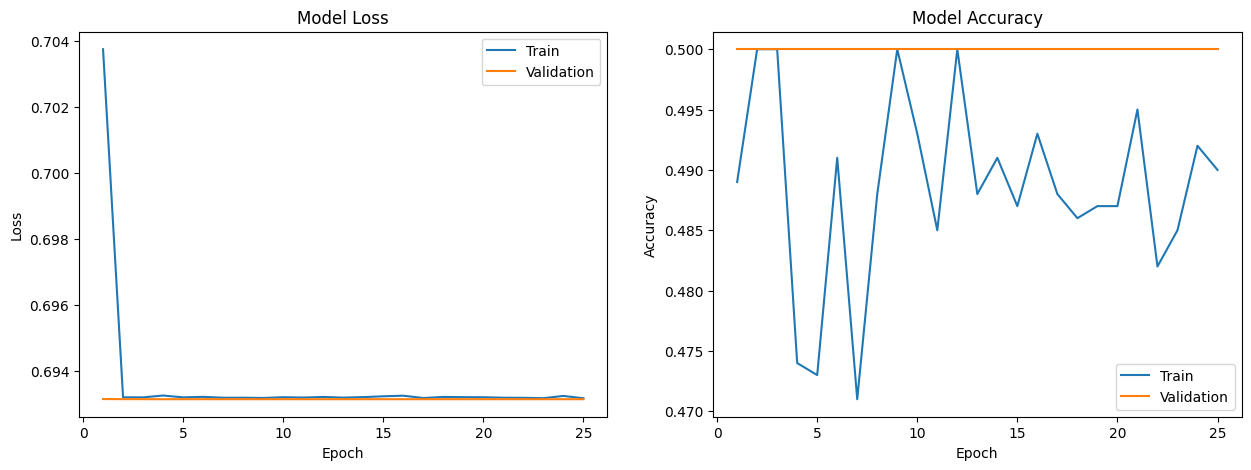

In [241]:
vgg_model = VGG16(include_top=False,weights=None, input_shape=(128, 128, 3))

X_train_preprocessed = preprocess_input(X_train_transformed)
X_test_preprocessed = preprocess_input(X_test_transformed)

train_features = vgg_model.predict(X_train_preprocessed)
test_features = vgg_model.predict(X_test_preprocessed)

train_features_flatten = train_features.reshape(train_features.shape[0], -1)
test_features_flatten = test_features.reshape(test_features.shape[0], -1)

model_vgg = Sequential()
model_vgg.add(Flatten(input_shape=train_features_flatten.shape[1:]))
model_vgg.add(Dense(256, activation='relu'))
model_vgg.add(Dense(2, activation='softmax'))

model_vgg.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_vgg_fit = model_vgg.fit(train_features_flatten, y_train, epochs=25, batch_size=16, validation_data=(test_features_flatten, y_test))

plot_metrics(model_vgg_fit)

In [246]:
### test strategies

if name == 'fine_tuning':               # On entraîne tout le réseau
    for layer in model.layers:
       layer.trainable = True
        
elif name == 'extraction_de_features':  # On entraîne seulement le nouveau classifieur 
    for layer in model.layers:
       layer.trainable = False

elif name == 'fine_tuning_partiel':    # On entraîne le nouveau classifieur et les couches hautes
    for layer in model.layers[:5]:
       layer.trainable = False